# Quarterback Passing Yards/Game Predictive Modeling

## Importing Passer Data

In [180]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

# Stats Stuff
from scipy import stats
from scipy.stats import skew
import statsmodels.api as sm


# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)


In [181]:
schedule = nfl.import_schedules([2024])

In [182]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2025), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [229]:
passer_data

,game_id,passer_player_name,posteam,defteam,season,week,home_team,away_team,air_yards,yards_after_catch,epa,complete_pass,incomplete_pass,interception,qb_hit,sack,pass_touchdown,passing_yards,cpoe,roof,surface
4,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,11.0,NaN,-1.542538,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-63.542004,outdoors,grass
7,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,4.0,4.0,0.889353,1.0,0.0,0.0,0.0,0.0,0.0,8.0,24.549454,outdoors,grass
8,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,39.0,5.0,2.468265,1.0,0.0,0.0,0.0,0.0,0.0,44.0,71.269318,outdoors,grass
9,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,12.0,0.0,1.879388,1.0,0.0,0.0,0.0,0.0,1.0,12.0,53.646080,outdoors,grass
12,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,1.0,11.0,0.731470,1.0,0.0,0.0,0.0,0.0,0.0,12.0,19.861258,outdoors,grass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489921,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,-1.0,1.0,-0.272676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.075715,outdoors,fieldturf
489922,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,13.0,0.0,0.936383,1.0,0.0,0.0,0.0,0.0,0.0,13.0,37.446724,outdoors,fieldturf
489924,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,29.0,NaN,-0.228033,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-31.641153,outdoors,fieldturf
489925,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,13.0,0.0,1.426387,1.0,0.0,0.0,0.0,0.0,0.0,13.0,38.319050,outdoors,fieldturf


## Passer Preprocessing & Feature Engineering

In [230]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

In [231]:
# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
passer_df = passer_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [232]:
# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Drop the home_team and away_team columns
passer_df = passer_df.drop(columns=['home_team', 'away_team'])

In [233]:
# Reorder the columns
passer_df = passer_df[['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

In [234]:
# Calculate the exponentially weighted moving average for each feature
passer_df['completion_percentage_ewma'] = passer_df.groupby('passer_player_name')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_attempts_ewma'] = passer_df.groupby('passer_player_name')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['air_yards_ewma'] = passer_df.groupby('passer_player_name')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['yards_after_catch_ewma'] = passer_df.groupby('passer_player_name')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['epa_ewma'] = passer_df.groupby('passer_player_name')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['interception_ewma'] = passer_df.groupby('passer_player_name')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['qb_hit_ewma'] = passer_df.groupby('passer_player_name')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['sack_ewma'] = passer_df.groupby('passer_player_name')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_touchdown_ewma'] = passer_df.groupby('passer_player_name')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['passing_yards_ewma'] = passer_df.groupby('passer_player_name')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['cpoe_ewma'] = passer_df.groupby('passer_player_name')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [235]:
# Drop the non-ewma columns
passer_df = passer_df.drop(columns=['completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe'])

## Defense Preprocessing & Feature Engineering

In [236]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

In [237]:
# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

In [238]:
# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
defense_df = defense_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [239]:
# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Drop the home_team and away_team columns
defense_df = defense_df.drop(columns=['home_team', 'away_team'])

In [240]:
# Reorder the columns
defense_df = defense_df[['defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

In [241]:
# Calculate the exponentially weighted moving average for each feature
defense_df['completion_percentage_ewma'] = defense_df.groupby('defteam')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_attempts_ewma'] = defense_df.groupby('defteam')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['air_yards_ewma'] = defense_df.groupby('defteam')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['yards_after_catch_ewma'] = defense_df.groupby('defteam')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['epa_ewma'] = defense_df.groupby('defteam')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['interception_ewma'] = defense_df.groupby('defteam')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['qb_hit_ewma'] = defense_df.groupby('defteam')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['sack_ewma'] = defense_df.groupby('defteam')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_touchdown_ewma'] = defense_df.groupby('defteam')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['passing_yards_ewma'] = defense_df.groupby('defteam')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['cpoe_ewma'] = defense_df.groupby('defteam')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [242]:
# Drop the non-ewma columns
defense_df = defense_df.drop(columns=['passing_yards','completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe'])

## Merging Passer & Defense Data

In [243]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_df.merge(defense_df, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))
# Get rid of flukey rows. Jury out on Taysom Hill I guess.
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8)]

filtered_with_ewma

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
0,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,173.0,False,21.0,outdoors,grass,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598,True,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598
1,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,349.0,True,47.0,outdoors,grass,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331,False,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331
2,2014_01_CAR_TB,D.Anderson,CAR,TB,2014,1,230.0,False,33.0,outdoors,grass,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589,True,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589
3,2014_01_CAR_TB,J.McCown,TB,CAR,2014,1,183.0,True,33.0,outdoors,grass,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191,False,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191
4,2014_01_CIN_BAL,A.Dalton,CIN,BAL,2014,1,301.0,False,38.0,outdoors,sportturf,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219,True,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6748,2024_03_PHI_NO,J.Hurts,PHI,NO,2024,3,311.0,False,37.0,dome,sportturf,0.771150,34.502832,241.430646,161.594642,-2.350847,1.049550,6.304153,3.128736,0.404279,276.028508,9.806723,True,0.695370,37.702864,320.912077,165.116990,-4.428504,0.963885,6.015722,3.172964,0.356015,288.028137,3.377774
6749,2024_03_SF_LA,B.Purdy,SF,LA,2024,3,292.0,False,30.0,dome,matrixturf,0.738309,31.253286,319.248695,57.281068,10.390618,0.231710,4.058320,2.192788,2.260245,292.181912,7.473561,True,0.685915,36.503721,334.530816,77.909885,8.116501,0.233649,3.678584,1.377913,2.063135,289.603465,2.527158
6750,2024_03_SF_LA,M.Stafford,LA,SF,2024,3,221.0,True,25.0,dome,matrixturf,0.661731,27.515754,243.125736,98.034767,0.608555,0.090585,6.395725,3.347680,0.807042,231.750317,3.032181,False,0.633160,28.028805,272.863258,77.761778,-0.983938,0.233339,5.455731,2.789464,0.725497,200.224847,1.121569
6752,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,324.0,True,38.0,outdoors,fieldturf,0.729274,36.380665,257.093181,115.619849,10.899412,0.016883,4.420252,2.311366,2.494750,292.143028,7.180779,False,0.726086,36.228201,298.165731,112.622051,13.486049,0.225780,3.555400,1.585342,2.570251,300.739734,6.179144


## Removing Outliers

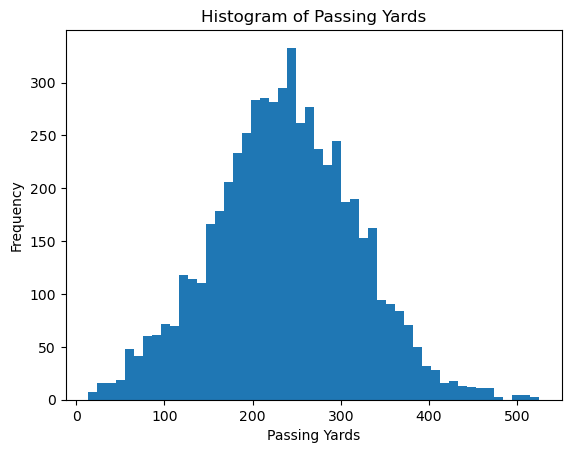

In [244]:
# Identify distribution shape to recreate after we get model results. This looks normal so using our projection for each QB for a week we will use RMSE
# as the standard deviation to create a normal distribution and assign a likelihood to each 
plt.hist(filtered_with_ewma['passing_yards'], bins=50)  # You can adjust the number of bins
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of Passing Yards')
plt.show()

## Exploratory Data Analysis

In [245]:
# Get an overview of the data
filtered_with_ewma.describe().round(2)

,season,week,passing_yards,pass_attempts,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
count,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00
mean,2018.68,9.51,236.79,32.16,0.66,31.83,264.05,108.46,0.90,0.75,5.05,2.22,1.46,234.67,0.19,0.66,33.75,280.63,114.52,0.55,0.83,5.41,2.39,1.53,247.68,0.22
std,2.95,5.44,81.26,9.17,0.08,7.51,79.37,36.97,8.03,0.65,2.17,1.27,0.89,66.64,7.01,0.07,5.83,69.62,31.45,7.99,0.68,2.03,1.26,0.82,53.63,6.24
min,2014.00,1.00,14.00,9.00,0.22,6.89,15.00,5.80,-29.73,0.00,0.00,0.00,0.00,22.00,-39.47,0.36,13.93,91.69,31.91,-27.07,0.00,0.00,0.00,0.00,81.57,-28.19
25%,2016.00,5.00,183.00,26.00,0.61,27.23,210.33,83.29,-4.45,0.23,3.49,1.26,0.82,192.20,-4.07,0.61,29.69,231.55,92.29,-4.66,0.25,3.97,1.47,0.92,209.60,-3.79
50%,2019.00,10.00,236.00,32.00,0.66,32.07,260.96,106.76,0.73,0.69,4.83,2.05,1.37,235.58,0.46,0.66,33.49,275.61,111.19,0.85,0.73,5.21,2.24,1.47,245.15,0.30
75%,2021.00,14.00,291.00,38.00,0.71,36.75,314.78,132.32,6.41,1.11,6.39,2.95,2.00,279.99,4.91,0.70,37.47,323.81,134.08,6.04,1.22,6.68,3.13,2.05,283.49,4.47
max,2024.00,22.00,525.00,67.00,1.00,61.00,603.72,250.26,26.29,4.15,14.94,8.25,5.52,483.02,23.10,0.89,61.00,627.07,244.09,27.12,4.01,14.39,8.42,4.96,458.00,20.70


## Modeling w/ Sci-kit Learn

maybe come back to the below cell and figure out how to transform these features into numerical values

In [246]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id'])

In [247]:
# #running on everything to get best params, once I get params take them adn make new model holding out 
# X = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, features]
# y = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, target]

# # Select columns for one-hot encoding and standard scaling
# categorical_columns = ['roof', 'surface']
# numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# # Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(), categorical_columns),
#         ('num', StandardScaler(), numeric_columns)
#     ])

# # Define the parameter grid for tuning
# param_grid = {
#     'num_leaves': [10, 20, 30, 40, 50],
#     'learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'max_depth': [-1, 5, 10, 15],
#     'min_data_in_leaf': [10, 20, 30, 50, 100],
#     'min_split_gain': [0.0, 0.1, 0.2],
#     'subsample_for_bin': [20000, 30000, 40000],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'bagging_fraction': [0.7, 0.8, 0.9],
#     'feature_fraction': [0.7, 0.8, 0.9],
#     'lambda_l1': [0, 0.1, 0.5, 1],
#     'lambda_l2': [0, 0.1, 0.5, 1],
#     'scale_pos_weight': [1, 10, 20],  # for imbalanced datasets
#     'objective': ['regression'],
#     'boosting_type': ['gbdt', 'dart', 'goss'],  # try different boosting types
#     'n_estimators': [500, 1000, 1500],
#     'metric': ['rmse']
# }

# # Instantiate the LGBM model
# model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42)

# # Define the pipeline with preprocessing and the model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', model)
# ])

# # Set up Bayesian Search using the pipeline
# opt = BayesSearchCV(
#     estimator=pipeline,  # Use the pipeline in Bayesian optimization
#     search_spaces={'regressor__' + k: v for k, v in param_grid.items()},  # Prefix params with 'regressor__'
#     n_iter=50,  # Number of iterations for Bayesian optimization
#     cv=3,
#     random_state=42,
#     verbose=1,
#     n_jobs=-1  # Use parallel processing
# )

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit the Bayesian optimization search
# opt.fit(X_train, y_train)

# # Get the best parameters
# best_params = opt.best_params_

# # Save best parameters as a dictionary (without 'regressor__' prefix)
# cleaned_best_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

In [248]:
# Define the best parameters from Bayesian optimization
best_params = {
    'bagging_fraction': 0.7,
    'boosting_type': 'goss',
    'colsample_bytree': 0.9,
    'feature_fraction': 0.8,
    'lambda_l1': 1,
    'lambda_l2': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'metric': 'rmse',
    'min_data_in_leaf': 10,
    'min_split_gain': 0.2,
    'n_estimators': 1000,
    'num_leaves': 10,
    'objective': 'regression',
    # 'scale_pos_weight': 10,
    'subsample': 0.9,
    'subsample_for_bin': 30000
}


In [249]:
# # Example: Setting quantile regression with a 50% (median) target
# best_params = {
#     'boosting_type': 'goss',
#     'objective': 'quantile',
#     'alpha': 0.5,  # Predict the median
#     'learning_rate': 0.01,
#     'n_estimators': 1000,
#     'num_leaves': 10,
#     'min_data_in_leaf': 10,
#     'max_depth': 5,
#     'metric': 'quantile'
# }

In [250]:
# Use data for all seasons before 2023 for training
X = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, features]
y = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, target]

In [251]:
# The data for 2024 that we will hold out for final testing
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
y_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, target]

In [272]:
# Ensure there are no missing values in X or y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Select columns for one-hot encoding and standard scaling
categorical_columns = ['roof', 'surface']
numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Instantiate the LGBM model with the best parameters
model = lgb.LGBMRegressor(**best_params, random_state=42, verbosity=-1)

# Define the pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Fit the model to all the data through 2023
pipeline.fit(X, y)

# Evaluate the model on the 2024 data
y_pred_2024 = pipeline.predict(X_2024)

# Print results (e.g., performance metrics)
print(f"2024 set performance: RMSE = {mean_squared_error(y_2024, y_pred_2024, squared=False)}")

2024 set performance: RMSE = 19.15609458740184


In [327]:
y_train_pred = pipeline.predict(X)
train_rmse = mean_squared_error(y, y_train_pred, squared=False)
print(f"Training RMSE: {train_rmse}")

y_test_pred = pipeline.predict(X_2024)
test_rmse = mean_squared_error(y_2024, y_test_pred, squared=False)
print(f"Test RMSE: {test_rmse}")

#holy fuck boss I'm not overfitting and it's a good model

Training RMSE: 18.676584039841348
Test RMSE: 19.15609458740184


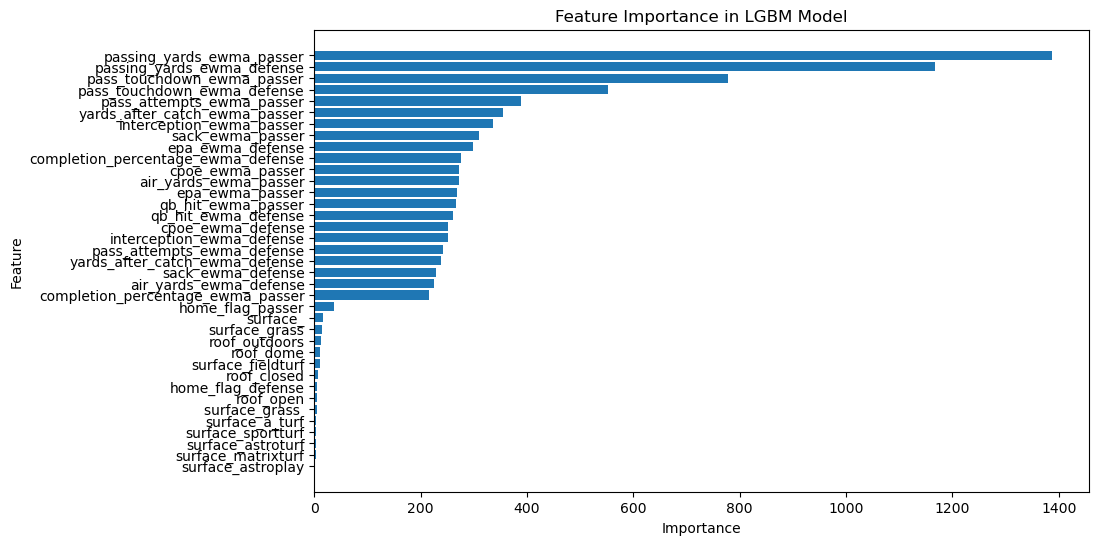

In [329]:
# Get the trained LGBMRegressor model from the pipeline
lgbm_model = pipeline.named_steps['regressor']

# Get feature names after preprocessing
categorical_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_columns)
numeric_features = numeric_columns  # These don't change from preprocessing

# Combine the categorical and numeric feature names
all_features = list(categorical_features) + numeric_features

# Extract feature importances from the LGBM model
feature_importances = lgbm_model.feature_importances_

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Optional: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in LGBM Model')
plt.gca().invert_yaxis()
plt.show()

In [253]:
# Adding identifier columns back after filtering for 2024 data
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
X_2024 = X_2024.merge(filtered_with_ewma[['game_id', 'passer_player_name', 'posteam', 'week']], left_index=True, right_index=True)

In [254]:
# Assuming you have a column like 'game_id' that identifies each game
game_id_column = 'game_id'
passer_column = 'passer_player_name'
team_column = 'posteam'
week_column = 'week'

# Preprocess the 2024 data using the pipeline (no need to use 'preprocessor' step directly)
y_pred_2024 = pipeline.predict(X_2024)

# Create a DataFrame to store predictions along with the game identifier
pred_df = pd.DataFrame({
    game_id_column: X_2024[game_id_column].values,
    passer_column: X_2024[passer_column].values,            # Passer name (QB)
    team_column: X_2024[team_column].values,  # Get the game IDs from X_2024
    week_column: X_2024[week_column].values,  #Week
    'true_passing_yards': y_2024.values,                     # Actual target values
    'predicted_passing_yards': y_pred_2024                   # Predicted values
})

pred_df['pass_yards_oe'] = pred_df['true_passing_yards'] - pred_df['predicted_passing_yards']

In [255]:
pred_df.sort_values('pass_yards_oe', ascending = False)

,game_id,passer_player_name,posteam,week,true_passing_yards,predicted_passing_yards,pass_yards_oe
92,2024_03_NYG_CLE,D.Jones,NYG,3,236.0,193.225352,42.774648
90,2024_03_NE_NYJ,A.Rodgers,NYJ,3,281.0,239.993807,41.006193
67,2024_03_CAR_LV,A.Dalton,CAR,3,319.0,280.241614,38.758386
24,2024_01_NYJ_SF,A.Rodgers,NYJ,1,167.0,130.451047,36.548953
71,2024_03_CHI_IND,C.Williams,CHI,3,363.0,328.505959,34.494041
...,...,...,...,...,...,...,...
78,2024_03_HOU_MIN,C.Stroud,HOU,3,215.0,251.853971,-36.853971
69,2024_03_CAR_LV,G.Minshew,LV,3,214.0,251.794327,-37.794327
63,2024_02_TB_DET,B.Mayfield,TB,2,185.0,225.122614,-40.122614
68,2024_03_CAR_LV,A.O'Connell,LV,3,82.0,125.826550,-43.826550


In [256]:
pred_df.shape

(100, 7)

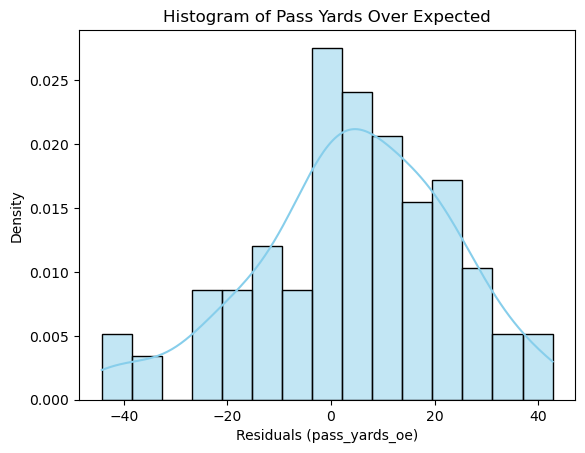

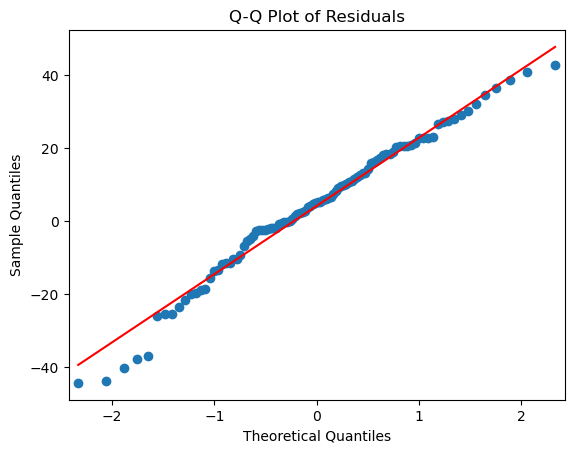

In [257]:
# Assuming 'residuals' is your numpy array of pass_yards_oe
residuals = pred_df['pass_yards_oe'].values

# Histogram and KDE
sns.histplot(residuals, bins=15, kde=True, stat='density', color='skyblue')
plt.title('Histogram of Pass Yards Over Expected')
plt.xlabel('Residuals (pass_yards_oe)')
plt.ylabel('Density')
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [258]:
# Fit Normal Distribution
mu_norm, sigma_norm = stats.norm.fit(residuals)

# Fit Student's t-Distribution
df_t, loc_t, scale_t = stats.t.fit(residuals)

# Fit Skew-Normal Distribution
shape_skew, loc_skew, scale_skew = stats.skewnorm.fit(residuals)

# Fit Laplace Distribution
loc_laplace, scale_laplace = stats.laplace.fit(residuals)

In [259]:
def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

def calculate_bic(n_params, log_likelihood, n_samples):
    return np.log(n_samples) * n_params - 2 * log_likelihood

n = len(residuals)

# Normal Distribution
loglik_norm = np.sum(stats.norm.logpdf(residuals, mu_norm, sigma_norm))
aic_norm = calculate_aic(2, loglik_norm)
bic_norm = calculate_bic(2, loglik_norm, n)

# t-Distribution
loglik_t = np.sum(stats.t.logpdf(residuals, df_t, loc_t, scale_t))
aic_t = calculate_aic(3, loglik_t)
bic_t = calculate_bic(3, loglik_t, n)

# Skew-Normal Distribution
loglik_skew = np.sum(stats.skewnorm.logpdf(residuals, shape_skew, loc_skew, scale_skew))
aic_skew = calculate_aic(3, loglik_skew)
bic_skew = calculate_bic(3, loglik_skew, n)

# Laplace Distribution
loglik_laplace = np.sum(stats.laplace.logpdf(residuals, loc_laplace, scale_laplace))
aic_laplace = calculate_aic(2, loglik_laplace)
bic_laplace = calculate_bic(2, loglik_laplace, n)

# Compare AIC and BIC
print('AIC Values:')
print(f'Normal: {aic_norm}, t-Distribution: {aic_t}, Skew-Normal: {aic_skew}, Laplace: {aic_laplace}')

print('BIC Values:')
print(f'Normal: {bic_norm}, t-Distribution: {bic_t}, Skew-Normal: {bic_skew}, Laplace: {bic_laplace}')

#lower is better for both

AIC Values:
Normal: 873.3868319027076, t-Distribution: 875.3672625567881, Skew-Normal: 872.0223460100375, Laplace: 878.6470311533138
BIC Values:
Normal: 878.5971722746838, t-Distribution: 883.1827731147524, Skew-Normal: 879.8378565680018, Laplace: 883.85737152529


In [260]:
from scipy.stats import skew

skewness = skew(residuals)
print(f'Skewness of residuals: {skewness}')

Skewness of residuals: -0.4252762277706582


In [261]:
# Example to calculate residual standard deviation for each QB
def calculate_qb_std(pred_df):
    """
    Calculates the standard deviation of residuals for each quarterback.
    :param pred_df: DataFrame with residuals calculated.
    :return: DataFrame with added 'residual_std' for each QB.
    """
    qb_groups = pred_df.groupby('passer_player_name')['pass_yards_oe']
    pred_df['residual_std'] = qb_groups.transform('std')  # Standard deviation for each QB
    return pred_df

#Assign
pred_df = calculate_qb_std(pred_df)

In [262]:
# Calculate the standard deviation of the residuals
residual_std = np.std(pred_df['pass_yards_oe'], ddof=1)  # ddof=1 ensures it's the sample standard deviation
print(f"Standard Deviation of Residuals: {residual_std}")

Standard Deviation of Residuals: 18.784288347694403


In [263]:
pred_df['residual_std_total'] = residual_std

In [264]:
# pred_df[pred_df['passer_player_name']== 'G.Minshew']

In [323]:
# Filter the DataFrame for the most recent week
most_recent_week = pred_df['week'].max()
recent_week_df = pred_df[pred_df['week'] == most_recent_week] 

recent_week_df

,game_id,passer_player_name,posteam,week,true_passing_yards,predicted_passing_yards,pass_yards_oe,residual_std,residual_std_total
65,2024_03_BAL_DAL,D.Prescott,DAL,3,379.0,372.931763,6.068237,18.947881,18.784288
66,2024_03_BAL_DAL,L.Jackson,BAL,3,182.0,183.955143,-1.955143,5.843113,18.784288
67,2024_03_CAR_LV,A.Dalton,CAR,3,319.0,280.241614,38.758386,NaN,18.784288
68,2024_03_CAR_LV,A.O'Connell,LV,3,82.0,125.826550,-43.826550,NaN,18.784288
69,2024_03_CAR_LV,G.Minshew,LV,3,214.0,251.794327,-37.794327,23.824280,18.784288
70,2024_03_CHI_IND,A.Richardson,IND,3,167.0,158.832498,8.167502,12.034200,18.784288
71,2024_03_CHI_IND,C.Williams,CHI,3,363.0,328.505959,34.494041,20.167349,18.784288
72,2024_03_DEN_TB,B.Mayfield,TB,3,163.0,184.672578,-21.672578,22.672505,18.784288
73,2024_03_DEN_TB,B.Nix,DEN,3,216.0,229.623478,-13.623478,16.101758,18.784288
74,2024_03_DET_ARI,J.Goff,DET,3,199.0,210.578797,-11.578797,11.464527,18.784288


In [266]:
def map_std_to_df(standard_deviation):
    """
    Maps the standard deviation of QB's passing performance to degrees of freedom for the t-distribution.
    :param standard_deviation: The standard deviation of the QB's passing yards or residuals.
    :return: Degrees of freedom (df) for the t-distribution.
    """
    # Example mapping logic
    if standard_deviation > 50:
        return 3  # Very high variance, allow more extreme outcomes
    elif 30 < standard_deviation <= 50:
        return 5  # High variance, some extreme outcomes possible
    elif 20 < standard_deviation <= 30:
        return 7  # Moderate variance
    else:
        return 10  # Low variance, tighter distribution

In [267]:
def get_qb_std(qb_name, pred_df):
    """
    Retrieves the standard deviation of the QB's residuals or passing yards from pred_df.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residuals.
    :return: The standard deviation for the given QB.
    """
    # Ensure the QB exists in the dataframe
    if qb_name not in pred_df['passer_player_name'].values:
        raise ValueError(f"Quarterback {qb_name} not found in pred_df.")
    
    # Get the QB's standard deviation from residuals or passing yards
    qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
    qb_std = qb_data['residual_std']  # Assuming residual_std column is already in pred_df
    
    # Print the standard deviation for debugging purposes
    print(f"Standard deviation for {qb_name}: {qb_std}")
    
    return qb_std

In [279]:
def calculate_league_wide_std(pred_df):
    """
    Calculates the standard deviation of true passing yards across the entire league.
    :param pred_df: DataFrame containing true passing yards.
    :return: League-wide standard deviation of true passing yards.
    """
    league_wide_std = pred_df['true_passing_yards'].std(ddof=1)  # Sample standard deviation (ddof=1)
    print(f"League-wide standard deviation of true passing yards: {league_wide_std:.2f}")
    return league_wide_std

In [321]:

# def print_all_qb_std(pred_df):
#     """
#     Prints the standard deviation of the QB's residuals or passing yards from pred_df for all quarterbacks.
#     :param pred_df: DataFrame containing predicted passing yards and residuals for each QB.
#     """
#     for index, row in pred_df.iterrows():
#         qb_name = row['passer_player_name']
#         qb_std = row['residual_std']
#         print(f"Standard deviation for {qb_name}: {qb_std}")

# # Assuming pred_df is available and has 'passer_player_name' and 'residual_std' columns.
# # Uncomment and run the function below once pred_df is defined in your environment.
# print_all_qb_std(pred_df)

In [320]:
# def simulate_passing_yards_with_limits(qb_name, pred_df, min_yards=100, max_yards=450, scaling_factor=1.2, num_simulations=10000):
#     """
#     Simulates passing yards using a t-distribution with degrees of freedom based on the QB's standard deviation,
#     applies limits to the minimum and maximum passing yards, and scales the standard deviation to widen the curve.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param pred_df: DataFrame containing predicted passing yards and residual standard deviation for each QB.
#     :param min_yards: Minimum passing yards limit.
#     :param max_yards: Maximum passing yards limit.
#     :param scaling_factor: Factor to scale the residual standard deviation to widen the curve.
#     :param num_simulations: Number of simulations to run.
#     :return: Simulated passing yards, predicted passing yards, residual std, and degrees of freedom.
#     """
#     # Retrieve the QB's standard deviation
#     qb_std = get_qb_std(qb_name, pred_df)
    
#     # Map the standard deviation to degrees of freedom
#     df = map_std_to_df(qb_std)
    
#     # Extract the predicted passing yards and residual standard deviation for the QB
#     qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
#     predicted_passing_yards = qb_data['predicted_passing_yards']
#     residual_std = qb_data['residual_std']
    
#     # Scale the standard deviation to widen the distribution
#     scaled_std = residual_std * scaling_factor
    
#     # Simulate passing yards using the t-distribution with dynamically adjusted df
#     simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=scaled_std, size=num_simulations)
    
#     # Apply minimum and maximum passing yards limits
#     simulations = np.clip(simulations, min_yards, max_yards)
    
#     return simulations, predicted_passing_yards, scaled_std, df

# def plot_qb_simulation_curve_with_guess_and_limits(qb_name, pred_df, user_guess=None, min_yards=100, max_yards=450, scaling_factor=1.2, num_simulations=10000):
#     """
#     Plots the distribution (curve) of simulated passing yards for a given QB, adds minimum and maximum passing yards limits,
#     and calculates the probability of exceeding the user_guess yards. Adds the prediction line and the guess line.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param pred_df: DataFrame containing predicted passing yards and residual standard deviation for each QB.
#     :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
#     :param min_yards: Minimum passing yards limit.
#     :param max_yards: Maximum passing yards limit.
#     :param scaling_factor: Factor to scale the residual standard deviation to widen the curve.
#     :param num_simulations: Number of simulations to run.
#     """
#     # Get the simulated passing yards, prediction, scaled residual std, and df for the QB
#     simulations, predicted_passing_yards, scaled_std, df = simulate_passing_yards_with_limits(qb_name, pred_df, min_yards, max_yards, scaling_factor, num_simulations)
    
#     # Print the degrees of freedom used for this QB
#     print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
#     # Plot the distribution of the simulated passing yards
#     plt.figure(figsize=(10, 6))
#     sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
#     # Add the predicted passing yards line
#     plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards")
    
#     # Add the user guess line and calculate the probability
#     probability = None
#     if user_guess is not None:
#         plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
#         # Calculate the probability of exceeding the user guess
#         probability = np.mean(simulations >= user_guess)
#         print(f"Probability of {qb_name} throwing at least {user_guess} yards: {probability:.4f}")
    
#     # Plot details
#     plt.title(f"Simulated Passing Yards for {qb_name} (Limits: {min_yards}-{max_yards} yards)")
#     plt.xlabel("Passing Yards")
#     plt.ylabel("Density")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     return simulations, probability

# # Usage example:
# if __name__ == "__main__":
#     qb_name = "P.Mahomes"  # Example quarterback name
#     user_guess = 320  # Example user guess for passing yards
    
#     # Plot the curve for Mahomes with t-distribution, scaled std, and limits
#     simulations, probability = plot_qb_simulation_curve_with_guess_and_limits(qb_name, pred_df, user_guess=user_guess)
    
#     if probability is not None:
#         print(f"The probability of {qb_name} throwing at least {user_guess} yards is {probability:.4f}")

In [316]:
# def simulate_passing_yards_nfl_trend(qb_name, week, pred_df, league_wide_std, num_simulations=10000, normal_weight=0.7):
#     """
#     Simulates passing yards using a combination of normal distribution and t-distribution
#     with adjusted NFL trends for realistic sportsbook odds.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param week: The week of the simulation.
#     :param pred_df: DataFrame containing predicted passing yards for each QB.
#     :param league_wide_std: League-wide standard deviation of true passing yards.
#     :param num_simulations: Number of simulations to run.
#     :param normal_weight: Weighting of normal distribution near the center (0.0 to 1.0).
#     :return: Simulated passing yards, predicted passing yards, and degrees of freedom.
#     """
#     # Filter for the specific QB and week
#     qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
#     if qb_data.empty:
#         print(f"No data found for {qb_name} in week {week}.")
#         return None, None, None
    
#     qb_data = qb_data.iloc[0]
#     predicted_passing_yards = qb_data['predicted_passing_yards']
#     residual_std = qb_data['residual_std']  # Use QB-specific standard deviation of residuals
    
#     # Set degrees of freedom for t-distribution based on NFL passing trends
#     # High degrees of freedom for most QBs (10-15) for smoother tails
#     if residual_std < 25:
#         df = 15  # Lower variability, more consistent QB
#     elif residual_std < 50:
#         df = 10  # Moderate variability
#     else:
#         df = 7   # High variability, bigger tails
    
#     print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
#     # Expand the standard deviation to widen the curve for more realistic odds
#     expanded_std = residual_std * 9  # Adjust for a wider range of realistic NFL outcomes
    
#     # Generate normal distribution simulations for values near the predicted passing yards
#     normal_simulations = np.random.normal(loc=predicted_passing_yards, scale=expanded_std, size=num_simulations)
    
#     # Generate t-distribution simulations for tail values
#     t_distribution_simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
#     # Combine the two distributions, with a smooth weighting between them
#     combined_simulations = np.where(np.abs(normal_simulations - predicted_passing_yards) <= expanded_std, 
#                                     normal_simulations * normal_weight + t_distribution_simulations * (1 - normal_weight),
#                                     t_distribution_simulations)
    
#     # Clip negative values (set minimum passing yards to 0 or reasonable floor)
#     combined_simulations = np.clip(combined_simulations, 0, np.inf)
    
#     return combined_simulations, predicted_passing_yards, df

# def plot_qb_simulation_nfl_trend(qb_name, week, pred_df, league_wide_std, user_guess=None, num_simulations=10000, normal_weight=0.7):
#     """
#     Plots the distribution (curve) of simulated passing yards based on NFL trends for sportsbook-like odds.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param week: The week of the simulation.
#     :param pred_df: DataFrame containing predicted passing yards and residuals for each QB.
#     :param league_wide_std: League-wide standard deviation of true passing yards.
#     :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
#     :param num_simulations: Number of simulations to run.
#     :param normal_weight: Weighting of normal distribution near the center (0.0 to 1.0).
#     """
#     # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB and week
#     simulations, predicted_passing_yards, df = simulate_passing_yards_nfl_trend(qb_name, week, pred_df, league_wide_std, num_simulations, normal_weight)
    
#     if simulations is None:
#         return None, None
    
#     # Plot the distribution of the simulated passing yards
#     plt.figure(figsize=(10, 6))
#     sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
#     # Add the predicted passing yards line
#     plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards (Week {week})")
    
#     # Add the user guess line and calculate the probability
#        # Add the user guess line and calculate the probability
#     probability_at_least = None
#     probability_at_most = None
#     if user_guess is not None:
#         plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        
#         # Calculate the probability of exceeding the user guess (at least)
#         probability_at_least = np.mean(simulations >= user_guess)
#         print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
        
#         # Calculate the probability of being at most the user guess
#         probability_at_most = 1 - probability_at_least
#         print(f"Probability of {qb_name} throwing at under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")
    
#     # Plot details
#     plt.title(f"Simulated Passing Yards for {qb_name} (Week {week}, NFL Passing Trends)")
#     plt.xlabel("Passing Yards")
#     plt.ylabel("Density")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     return simulations, probability

# # Example usage:
# if __name__ == "__main__":
#     qb_name = "J.Goff"
#     week = 3  # Example week
#     user_guess = 1 # User guess for testing
    
#     # Calculate league-wide standard deviation for fallback use
#     league_wide_std = calculate_league_wide_std(pred_df)
    
#     # Plot the NFL trend curve for the QB
#     simulations, probability = plot_qb_simulation_nfl_trend(qb_name, week, pred_df, league_wide_std, user_guess=user_guess, normal_weight=.8)

In [317]:
# Count where predicted passing yards is over the true passing yards
over_predictions = pred_df[pred_df['predicted_passing_yards'] > pred_df['true_passing_yards']].shape[0]

# Count where predicted passing yards is under the true passing yards
under_predictions = pred_df[pred_df['predicted_passing_yards'] < pred_df['true_passing_yards']].shape[0]

over_predictions, under_predictions

(39, 61)

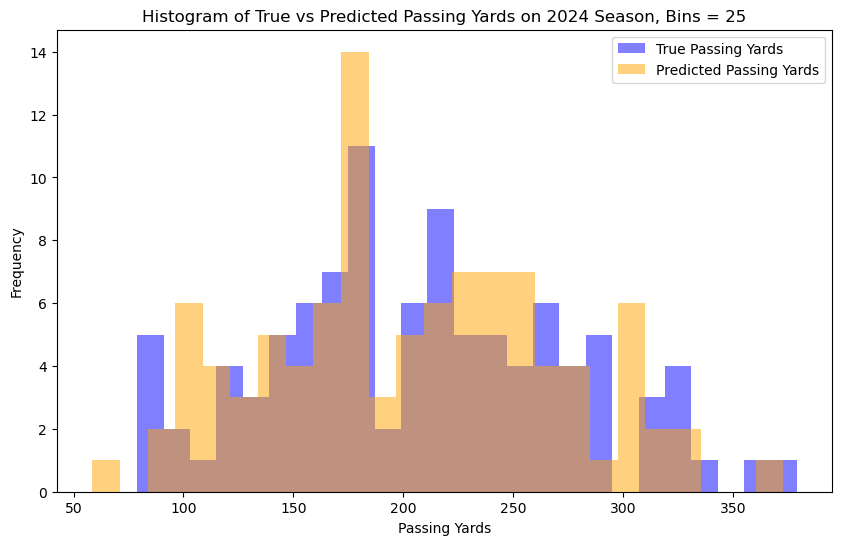

In [319]:

# Plotting the histogram of predicted passing yards and true passing yards
plt.figure(figsize=(10, 6))

# Plot histogram for true passing yards
plt.hist(pred_df['true_passing_yards'], bins=25, alpha=0.5, label='True Passing Yards', color='blue')

# Plot histogram for predicted passing yards
plt.hist(pred_df['predicted_passing_yards'], bins=25, alpha=0.5, label='Predicted Passing Yards', color='orange')

# Adding labels and title
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of True vs Predicted Passing Yards on 2024 Season, Bins = 25')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [294]:
# def simulate_passing_yards_adjusted(qb_name, week, pred_df, league_wide_std, num_simulations=10000, normal_weight=0.7, range_adjust=100):
#     """
#     Simulates passing yards using a combination of normal distribution and t-distribution,
#     and adjusts the range to focus predictions around ±100 yards for sportsbook-like odds.
#     """
#     # Filter for the specific QB and week
#     qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
#     if qb_data.empty:
#         print(f"No data found for {qb_name} in week {week}.")
#         return None, None
    
#     qb_data = qb_data.iloc[0]
#     predicted_passing_yards = qb_data['predicted_passing_yards']
#     residual_std = qb_data['residual_std']  # Use QB-specific standard deviation of residuals
    
#     # Set degrees of freedom for t-distribution based on NFL passing trends
#     if residual_std < 25:
#         df = 15  # Lower variability, more consistent QB
#     elif residual_std < 50:
#         df = 10  # Moderate variability
#     else:
#         df = 7   # High variability, bigger tails
    
#     print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
#     # Expand the standard deviation to focus on a ±100 yard range around the prediction
#     expanded_std = range_adjust  # Adjusting the range to +-100 yards

#     # Generate normal distribution simulations for values near the predicted passing yards
#     normal_simulations = np.random.normal(loc=predicted_passing_yards, scale=expanded_std, size=num_simulations)
    
#     # Generate t-distribution simulations for tail values
#     t_distribution_simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
#     # Combine the two distributions, with a smooth weighting between them
#     combined_simulations = np.where(np.abs(normal_simulations - predicted_passing_yards) <= expanded_std, 
#                                     normal_simulations * normal_weight + t_distribution_simulations * (1 - normal_weight),
#                                     t_distribution_simulations)
    
#     # Clip negative values (set minimum passing yards to 0 or reasonable floor)
#     combined_simulations = np.clip(combined_simulations, 0, np.inf)
    
#     return combined_simulations, predicted_passing_yards, df


# def plot_qb_simulation_adjusted(qb_name, week, pred_df, league_wide_std, user_guess=None, num_simulations=10000, normal_weight=0.7, range_adjust=100):
#     """
#     Plots the distribution (curve) of simulated passing yards based on NFL trends for sportsbook-like odds,
#     and calculates the custom price for both over and under the user guess with adjusted range for tighter predictions.
#     """
#     # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB and week
#     simulations, predicted_passing_yards, df = simulate_passing_yards_adjusted(qb_name, week, pred_df, league_wide_std, num_simulations, normal_weight, range_adjust)
    
#     if simulations is None:
#         return None, None
    
#     # Plot the distribution of the simulated passing yards
#     plt.figure(figsize=(10, 6))
#     sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
#     # Add the predicted passing yards line
#     plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards (Week {week})")
    
#     # Add the user guess line and calculate the probability
#     probability_at_least = None
#     probability_at_most = None
#     if user_guess is not None:
#         plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        
#         # Calculate the probability of exceeding the user guess (at least)
#         probability_at_least = np.mean(simulations >= user_guess)
#         print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
        
#         # Calculate the probability of being at most the user guess
#         probability_at_most = 1 - probability_at_least
#         print(f"Probability of {qb_name} throwing under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")
        
#         # Calculate custom prices for over and under using the provided logic
#         price_at_least = calculate_custom_price(probability_at_least)
#         price_at_most = calculate_custom_price(probability_at_most)
#         print(f"Custom Price for over {user_guess} yards: {price_at_least}")
#         print(f"Custom Price for under {user_guess} yards: {price_at_most}")
    
#     # Plot details
#     plt.title(f"Simulated Passing Yards for {qb_name} (Week {week}, Adjusted for ±100 Yards)")
#     plt.xlabel("Passing Yards")
#     plt.ylabel("Density")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     return simulations, probability_at_least, probability_at_most, price_at_least, price_at_most

# # Example usage:
# if __name__ == "__main__":
#     qb_name = "J.Goff"
#     week = 3  # Example week
#     user_guess = 275  # Example user guess for passing yards
    
#     # Calculate league-wide standard deviation for fallback use
#     league_wide_std = calculate_league_wide_std(pred_df)
    
#     # Plot the NFL trend curve for the QB and calculate custom prices, adjusting for tighter range predictions
#     simulations, probability_at_least, probability_at_most, price_at_least, price_at_most = plot_qb_simulation_adjusted(qb_name, week, pred_df, league_wide_std, user_guess=user_guess, normal_weight=0.7, range_adjust=100)

League-wide standard deviation of true passing yards: 68.44
Degrees of freedom (df) for J.Allen: 15
Probability of J.Allen throwing over or exactly 275 yards in Week 3: 0.3887
Probability of J.Allen throwing under or exactly 275 yards in Week 3: 0.6113
Custom Price for over 275 yards: +157
Custom Price for under 275 yards: -157


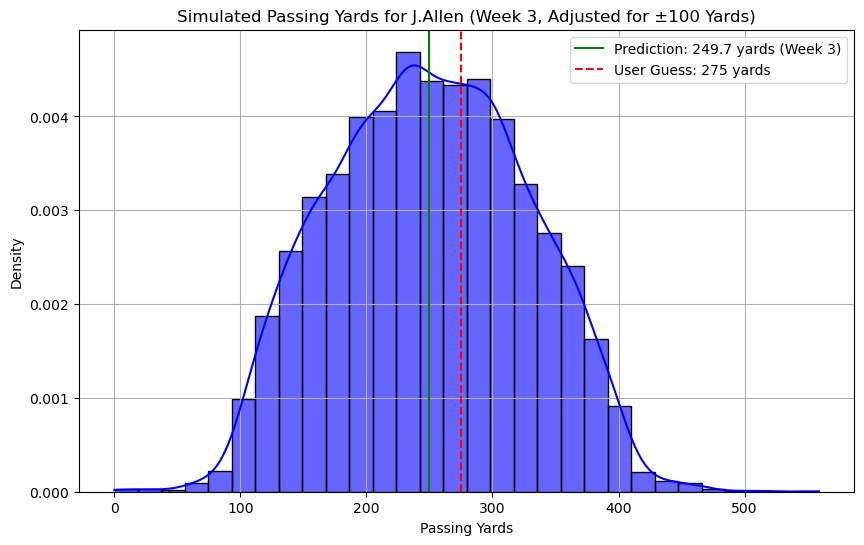

In [315]:
def simulate_passing_yards_adjusted(qb_name, week, pred_df, league_wide_std, num_simulations=10000, normal_weight=0.7, range_adjust=100, seed=31):
    """
    Simulates passing yards using a combination of normal distribution and t-distribution,
    and adjusts the range to focus predictions around ±100 yards for sportsbook-like odds.
    """

    """
    Simulates passing yards using a combination of normal distribution and t-distribution,
    and adjusts the range to focus predictions around ±100 yards for sportsbook-like odds.
    A random seed can be passed in for reproducible results.
    """
    if seed is not None:
        np.random.seed(seed)  # Set the random seed for reproducibility
    
    # Filter for the specific QB and week
    qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
    if qb_data.empty:
        print(f"No data found for {qb_name} in week {week}.")
        return None, None
    
    qb_data = qb_data.iloc[0]
    predicted_passing_yards = qb_data['predicted_passing_yards']
    residual_std = qb_data['residual_std']  # Use QB-specific standard deviation of residuals
    
    # Set degrees of freedom for t-distribution based on NFL passing trends
    if residual_std < 25:
        df = 15  # Lower variability, more consistent QB
    elif residual_std < 50:
        df = 10  # Moderate variability
    else:
        df = 7   # High variability, bigger tails
    
    print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
    # Expand the standard deviation to focus on a ±100 yard range around the prediction
    expanded_std = range_adjust  # Adjusting the range to +-100 yards

    # Generate normal distribution simulations for values near the predicted passing yards
    normal_simulations = np.random.normal(loc=predicted_passing_yards, scale=expanded_std, size=num_simulations)
    
    # Generate t-distribution simulations for tail values
    t_distribution_simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
    # Combine the two distributions, with a smooth weighting between them
    combined_simulations = np.where(np.abs(normal_simulations - predicted_passing_yards) <= expanded_std, 
                                    normal_simulations * normal_weight + t_distribution_simulations * (1 - normal_weight),
                                    t_distribution_simulations)
    
    # Clip negative values (set minimum passing yards to 0 or reasonable floor)
    combined_simulations = np.clip(combined_simulations, 0, np.inf)
    
    return combined_simulations, predicted_passing_yards, df

def calculate_custom_price(probability):
    """
    Calculate a custom price based on the given probability using American odds logic.
    :param probability: The probability of an event (e.g., over/under on passing yards).
    :return: Formatted price in the form of American odds.
    """
    # Handle edge cases where probability is zero or near 1 (avoiding division by zero)
    if probability <= 0:
        return None
    elif probability >= 1:
        return "-100"  # Near certainty results in a very small return

    # Different formula based on whether the probability represents a favorite or underdog
    if probability >= 0.5:
        # For probabilities > 50%, use negative odds (favorites)
        price = -100 * (probability / (1 - probability))
    else:
        # For probabilities < 50%, use positive odds (underdogs)
        price = (100 / probability) - 100

    return "{:+.0f}".format(price)  # Format as integer with "+" or "-" sign

def plot_qb_simulation_adjusted(qb_name, week, pred_df, league_wide_std, user_guess=None, num_simulations=10000, normal_weight=0.7, range_adjust=100):
    """
    Plots the distribution (curve) of simulated passing yards based on NFL trends for sportsbook-like odds,
    and calculates the custom price for both over and under the user guess with adjusted range for tighter predictions.
    """
    # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB and week
    simulations, predicted_passing_yards, df = simulate_passing_yards_adjusted(qb_name, week, pred_df, league_wide_std, num_simulations, normal_weight, range_adjust)
    
    if simulations is None:
        return None, None
    
    # Plot the distribution of the simulated passing yards
    plt.figure(figsize=(10, 6))
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add the predicted passing yards line
    plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards (Week {week})")
    
    # Add the user guess line and calculate the probability
    probability_at_least = None
    probability_at_most = None
    if user_guess is not None:
        plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        
        # Calculate the probability of exceeding the user guess (at least)
        probability_at_least = np.mean(simulations >= user_guess)
        print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
        
        # Calculate the probability of being at most the user guess
        probability_at_most = 1 - probability_at_least
        print(f"Probability of {qb_name} throwing under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")
        
        # Calculate custom prices for over and under using adjusted logic
        price_at_least = calculate_custom_price(probability_at_least)
        price_at_most = calculate_custom_price(probability_at_most)
        print(f"Custom Price for over {user_guess} yards: {price_at_least}")
        print(f"Custom Price for under {user_guess} yards: {price_at_most}")
    
    # Plot details
    plt.title(f"Simulated Passing Yards for {qb_name} (Week {week}, Adjusted for ±100 Yards)")
    plt.xlabel("Passing Yards")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return simulations, probability_at_least, probability_at_most, price_at_least, price_at_most

# Example usage:
if __name__ == "__main__":
    qb_name = "J.Allen"
    week = 3  # Example week
    user_guess = 275  # Example user guess for passing yards
    
    # Calculate league-wide standard deviation for fallback use
    league_wide_std = calculate_league_wide_std(pred_df)
    
    # Plot the NFL trend curve for the QB and calculate custom prices, adjusting for tighter range predictions
    simulations, probability_at_least, probability_at_most, price_at_least, price_at_most = plot_qb_simulation_adjusted(qb_name, week, pred_df, league_wide_std, user_guess=user_guess, normal_weight=0.8, range_adjust=180)